In [1]:
!pip install wordcloud

In [2]:
%run ../preprocessing.py

In [3]:
import os
import re
import csv
import json
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
ROOT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/"
DATASET_PATH = ROOT_FOLDER + "dataset/"

In [5]:
# NLTK stopwords
stopwords = set(['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 'auraient', 'avais', 'avait', 'avions', 'aviez', 'avaient', 'eut', 'eûmes', 'eûtes', 'eurent', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eusse', 'eusses', 'eût', 'eussions', 'eussiez', 'eussent'])

## Import dataset

In [6]:
labels = ['santé', 'science_high-tech', 'sports', 'économie', 'international', 'culture', 'france', ]# 'homepage', 

In [7]:
def append_(dictionnary, key, value):
    if key in dictionnary:
      dictionnary[key].append(value)
    else:
      dictionnary[key] = [value]

In [8]:
def get_main_category(dictOfNames):
    new_dict = {}
    try:
        for (key,value) in dictOfNames.items():
            #if "score" in key or "applenews" in key or "homepage" in key:
            #    continue
            new_key = re.sub(r'desktop_|mobile_webview_', "", key)
            new_key = re.sub(r'google_', "", new_key)
            if new_key not in labels:
                continue
            if new_key not in new_dict:
                new_dict[new_key] = 0
            new_dict[new_key] += value
        #return [key for key in new_dict.keys()]
        return max(new_dict, key=new_dict.get)
    except ValueError as e :
        return ""

In [9]:
title_lengths = {} # {1: 54, ...}
category_count = {} # { category_1: ["article_1"]}

with open(DATASET_PATH+'shuffled_since_january.csv', newline='') as csvfile:
  reader = csv.reader(csvfile, delimiter=',', quotechar='"')
  next(reader)
  for i, row in enumerate(reader):
    if len(row) != 5:
      continue

    category = ""
    if row[4] != {} and row[4] != "":
        try:
            category = get_main_category(json.loads(row[4]))
        except Exception as e:
            print(row)
            print(row[4])
            assert False
    if category == "":
        continue

    text = clean_text(row[0], remove_stopwords=True, lower=True)
    append_(category_count, category, text)
    append_(title_lengths, len(re.split(r'\W', text)), 1)

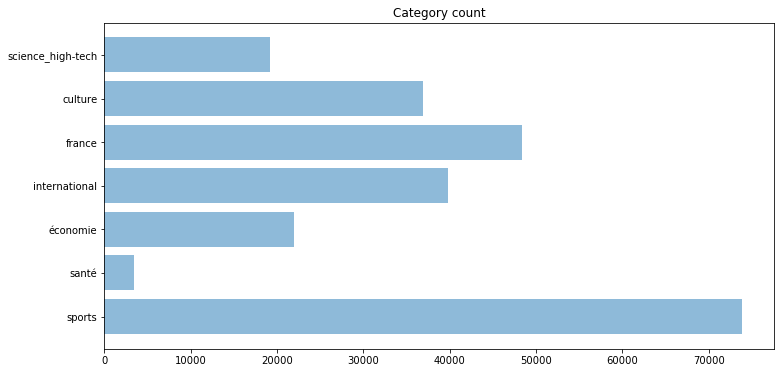

In [10]:
categories = category_count.keys()
y_pos = np.arange(len(categories))

plt.figure(figsize=(12, 6))
plt.barh(y_pos, [len(value) for value in category_count.values()], align='center', alpha=0.5)
plt.yticks(y_pos, category_count.keys())
plt.title('Category count')


plt.savefig("./category_count.png")
plt.show()

In [11]:
max_value = max([len(value) for value in category_count.values()])

print({key: (max_value / len(value)) for key, value in category_count.items()})
print({key: len(value) for key, value in category_count.items()})
print(category_count.keys())

{'sports': 1.0, 'santé': 21.571553738317757, 'économie': 3.357928714311693, 'international': 1.854033837040012, 'france': 1.5276950442624306, 'culture': 2.001381926568216, 'science_high-tech': 3.8443241555197}
{'sports': 73861, 'santé': 3424, 'économie': 21996, 'international': 39838, 'france': 48348, 'culture': 36905, 'science_high-tech': 19213}
dict_keys(['sports', 'santé', 'économie', 'international', 'france', 'culture', 'science_high-tech'])


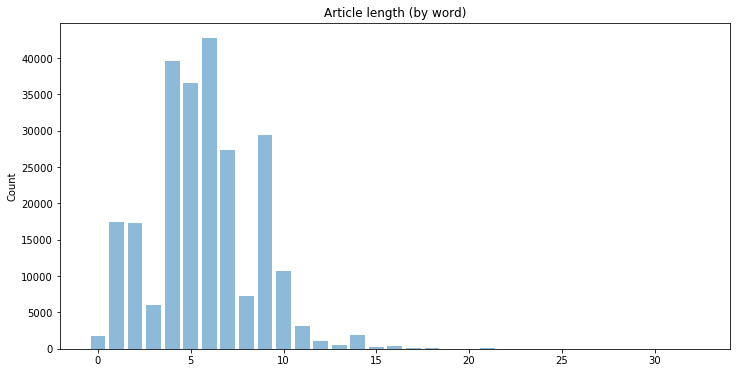

In [12]:
categories = title_lengths.keys()
y_pos = np.arange(len(categories))

plt.figure(figsize=(12, 6))
plt.bar(y_pos, [len(value) for value in title_lengths.values()], align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Article length (by word)')

plt.savefig("./article_length.png")
plt.show()

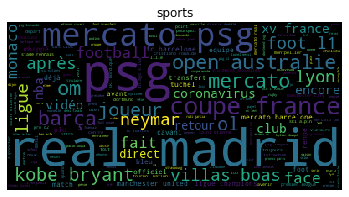

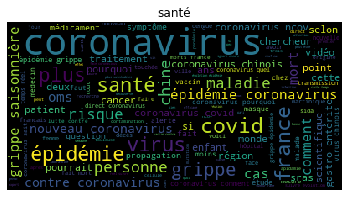

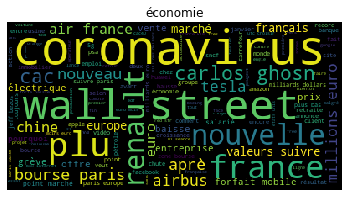

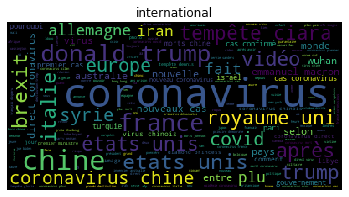

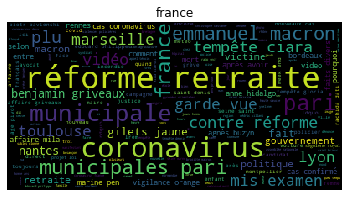

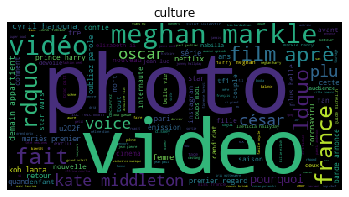

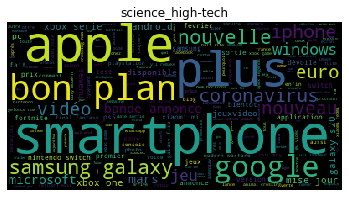

In [13]:
categories = len(category_count.keys())

for idx, (category, text) in enumerate(category_count.items()):
    wordcloud = WordCloud().generate(". ".join(text))

    fig, ax = plt.subplots()

    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(category)
    #plt.figure(figsize=(8, 6))
    plt.show()

In [14]:
from sklearn.utils import class_weight

labels_weight = class_weight.compute_class_weight(
    'balanced',
    labels,
    list(pd.core.common.flatten([[key] * len(val) for key, val in category_count.items()])),
)
print(labels)

dict_weight = [{idx: label} for idx, label in enumerate(labels_weight)]
print(dict_weight)
labels_weight = np.array([labels_weight[q] for q, _ in enumerate(labels)])
print(labels_weight)


['santé', 'science_high-tech', 'sports', 'économie', 'international', 'culture', 'france']
[{0: 10.162925567423231}, {1: 1.8111620851952919}, {2: 0.4711262661331033}, {3: 1.5820084171148001}, {4: 0.8734840389290914}, {5: 0.9429035941703602}, {6: 0.7197372619934049}]
[10.16292557  1.81116209  0.47112627  1.58200842  0.87348404  0.94290359
  0.71973726]
